In [7]:
# Import Python libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets


In [2]:
def show_image(image) -> None:
    """
    Displays a color image in the Jupyter Notebook.
    """
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()


def draw_contour(image, contour, color):
    """
    Draws a contour on the provided image.

    Args:
        image: The image on which to draw the contour.
        contour: The contour to draw on the image.
        color: The color to draw the contour in BGR format.
    """
    cv.drawContours(image, [contour], 0, color, 3)


def draw_circle(color_image, center, color, radius = 6):
    """
    Draws a circle on the provided image.

    Args:
        color_image: The color image on which to draw the contour.
        center: The pixel (row, column) of the center of the image.
        color: The color to draw the circle in BGR format.
        radius: The radius of the circle in pixels.
    """
    # cv.circle expects the center in (column, row) format
    cv.circle(color_image, (center[1], center[0]), radius, color, -1)


def show_color_bgr(blue, green, red):
    """
    Displays a color specified in the BGR format.
    """
    rectangle = plt.Rectangle((0,0), 50, 50, fc=(red/255, green/255, blue/255))
    plt.gca().add_patch(rectangle)
    plt.show()


def show_color_hsv(hue, saturation, value):
    """
    Displays a color specified in the HSV format
    """
    # Convert from hsv to bgr
    hsv = np.array([[[hue, saturation, value]]], np.uint8)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

    show_color_bgr(bgr[0][0][0], bgr[0][0][1], bgr[0][0][2])

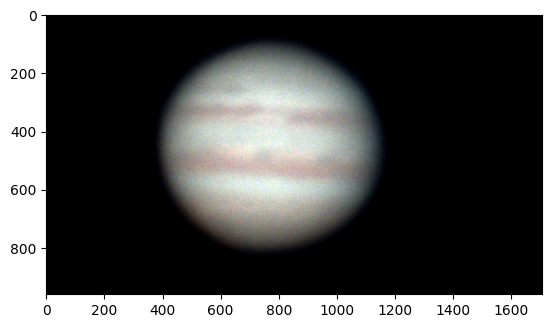

In [3]:
image = cv.imread("../../Resources/Input and Output/input/S__31277060.jpg")
show_image(image)

blue: 244
green: 247
red: 232


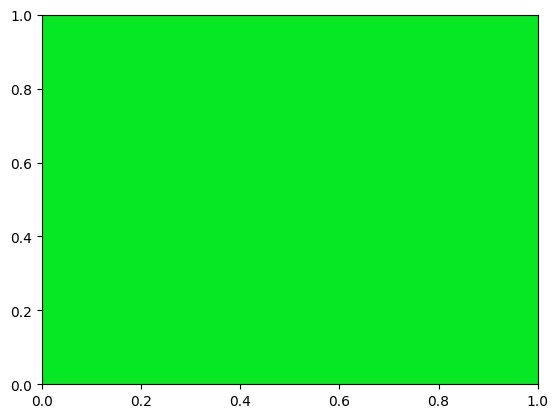

In [6]:
# Calculate center row and column
row =400
col = 800

# Extract and print blue, green, and red values
h = image[row][col][0]
s = image[row][col][1]
v = image[row][col][2]

print("blue:", h)
print("green:", s)
print("red:", v)

# Display this color
show_color_hsv(h, s, v)

In [8]:
# BGR color
widgets.interact(show_color_bgr,
                 blue=widgets.IntSlider(0, 0, 255, continuous_update=False),
                 green=widgets.IntSlider(0, 0, 255, continuous_update=False),
                 red=widgets.IntSlider(0, 0, 255, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='blue', max=255), IntSlider(valu…

In [9]:
# HSV color
widgets.interact(show_color_hsv,
                 hue=widgets.IntSlider(0, 0, 180, continuous_update=False),
                 saturation=widgets.IntSlider(255, 0, 255, continuous_update=False),
                 value=widgets.IntSlider(255, 0, 255, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='hue', max=180), IntSlider(value…

In [10]:
def get_mask(image, hsv_lower, hsv_upper):
    """
    Returns a mask containing all of the areas of image which were between hsv_lower and hsv_upper.

    Args:
        image: The image (stored in BGR) from which to create a mask.
        hsv_lower: The lower bound of HSV values to include in the mask.
        hsv_upper: The upper bound of HSV values to include in the mask.
    """
    # Convert hsv_lower and hsv_upper to numpy arrays so they can be used by OpenCV
    hsv_lower = np.array(hsv_lower)
    hsv_upper = np.array(hsv_upper)

    # TODO: Use the cv.cvtColor function to switch our BGR colors to HSV colors
    image = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    # TODO: Use the cv.inRange function to highlight areas in the correct range
    mask = cv.inRange(image, hsv_lower, hsv_upper)

    return mask

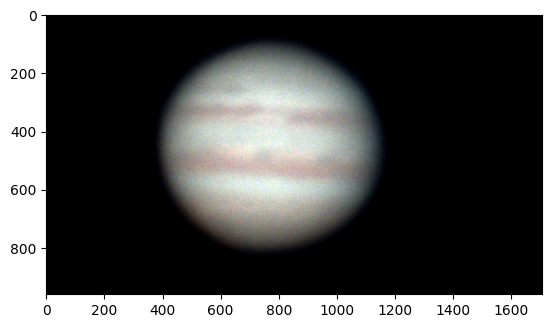

In [11]:
show_image(image)

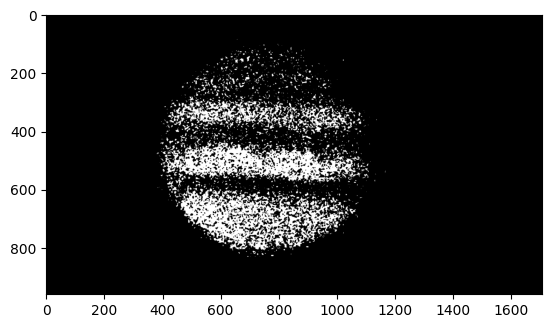

In [21]:
hsv = ((1, 0, 0), (30, 255, 255))

mask = get_mask(image, *hsv)
show_image(mask)

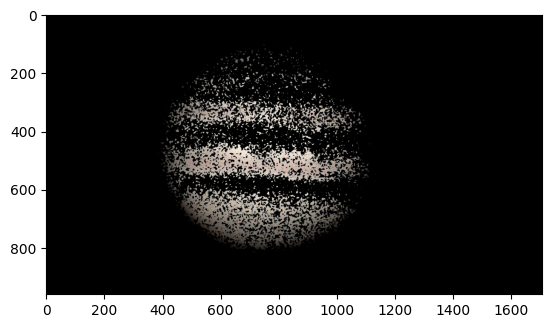

In [22]:
masked_image = cv.bitwise_and(image, image, mask=mask)
show_image(masked_image)